<h1><center>
Rover project <br></center></h1>
<h4><center>
Roberto Lucchesi - 1744941 </center></h4>


<h2><center>Introduction</center></h2>

NASA’s Mars Curiosity Rover is a mobile robot that is exploring the Gale Crater on Mars to search areas of the red planet for past or present conditions favorable for life.<br>
The following data of the rover should be considered:

- Maximum velocity of the rover: $V_{max} = 0.04$ m/s <br>
- Wheel base: L = 3 m

All the code here presented has been developed in Python within a Jupyter Notebook. Data provided in `.mat` has been converted to `.csv` and loaded into the program. This Python program makes use of `numpy` and `matplotlib` to replicate MATLAB functionalities.


We begin by importing all needed modules to run the script. The custom imports that are specific to one task are marked with comments, otherwise assume that the import is used throughout the code. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Comment this imports if you are not using Jupyter Notebook
from IPython.display import display
from IPython.display import Markdown as md, Javascript, HTML

# custom modules
from graph import *
from AStar import * # code for path planning task
from grid import *
from traj_gen import * # code for navigation task
from rover import *
from utils import *
from localization import * # code for localization task



For the operative ground, a 45x30 km map is provided in greyscale, with a resolution of 10m. Inaccessible regions are identified with a `255` (white) boundary margin.  
We load the data provided:

<center>
  
 `mars_map` contains the grayscale operative map. <br>
 `obstacle_map` containst the obstacle boundaries <br>
   `pos_lm` contains all landmark positions <br>

</center>

We also initialize all points of interest: <br>


<center>

&#128994; $P_0$ = (42.38, 11.59) km  <br>
&#128309; $P_1$ = (33.07, 19.01) km  <br>
&#128308; $P_2$  = (10.87, 25.67) km 

</center>

At last, we initialize a `Grid` object with the map, obstacles and landamarks provided. This class is responsible to do boundary checking and plotting. 

<div class="alert alert-block alert-warning">
<b>Attention:</b> Due to the data files being too large for Github, they are not provided on the main repo.
</div>

In [2]:
dataFolder = "data/"

## Constants of the problem
maxVel = 0.04; # [m/s] maximum velocity of the rover 
LAxis = 3; # [m] length of the rover wheel axis

# Points of interest
P0 = np.array([42.38*10**3, 11.59*10**3])
P1 = np.array([33.07*10**3, 19.01*10**3])
P2 = np.array([10.87*10**3, 25.67*10**3])

P0p = Path(P0, 'go')
P1p = Path(P1, 'bo')
P2p = Path(P2, 'ro')

### load data from csv file
# landmarks coordinates
Xlm = np.loadtxt(dataFolder +"Xlm.csv")
Ylm = np.loadtxt(dataFolder +"Ylm.csv")
pos_lm = np.array([Xlm, Ylm]).T # landmark positions

# map and obstacle map
mars_map = np.loadtxt(dataFolder +"map.csv", delimiter=",")
obstacle_map = np.loadtxt(dataFolder +"obstacle.csv", delimiter=",")

sup_map = map_obstacle(mars_map, obstacle_map)

# Create mars_grid (45kmx30km, 10m resolution)
mars_grid = Grid(xlim = 45000, ylim = 30000, res = 10, 
            image = sup_map, obstacle = obstacle_map, 
            landmarks = pos_lm, corner = 'll') 

We print the map, with the points of interests and all landmarks. The steep regions are evidentiated with a white contour.

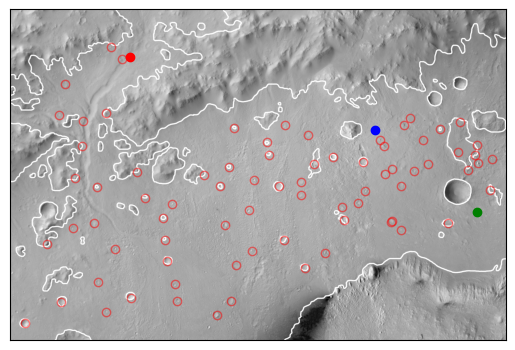

In [3]:
mars_grid.plot_on([P0p,P1p,P2p], landmarks=True)
plt.show()



<h2><center> Task 1: Navigation </center></h2> 

The first task requires the determination of the trajectory from &#128309; $P_0$ to &#128308; $P_1$. We also need to arrive at the target with an heading $\theta_f$  = 180, while we start with an heading of $\theta_0$ = 90. The heading angle is measured by considering positive an anti-clockwise rotation from the __x__-axis (i.e. $\theta_0$ is parallel to the North direction.)  


For this problem then our state is going to be represented with a 3x1 vector:



<center>

__q__ = $\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ and    $\dot{q}$ =  $\begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix}$

</center>



We first run the __A*__ algorithm to have an idea on how much does it cost the minimum expensive path from $P_0$ to $P_1$, plotting the result on the map.

In [4]:
""" # A* algorithm from P0 to P1
path, gScore = AStar(mars_grid, P0, P1) 
np_path = np.array(path)
print("A* cost: ", gScore)
# Plot the path
 """

' # A* algorithm from P0 to P1\npath, gScore = AStar(mars_grid, P0, P1) \nnp_path = np.array(path)\nprint("A* cost: ", gScore)\n# Plot the path\n '

To achieve a realizable trajectory we employ the <b>Moving to a pose</b> control scheme, implemented in the `control_pose` function.  

The values here used for $k_\rho$, $k_\alpha$, and $k_\beta$ are handpicked to achieve the requisite of not entering the forbidden regions marked on the map.

In [5]:
# Find trajectory via manual tuning of control_pose gains

Curiosity_rover = Rover(maxVel, LAxis)

np_P0 = np.array([P0[0],P0[1], np.deg2rad(90)])
np_P1 = np.array([P1[0],P1[1], np.deg2rad(180)])

q, qd, t  = control_pose(Curiosity_rover, np_P0, np_P1, 1, 
                         k_rho=0.04, k_alpha=0.09, k_beta=-0.115)


cost_traj = cost_path(q[:,0:2])
print("Cost of the trajectory: ", cost_traj)    
print("Time in sols: ", t/sol_in_secs)
print("Theta: ", np.rad2deg(q[-1,2]))





Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.115)
Cost of the trajectory:  13244.482120523948
Time in sols:  3.7301727883970917
Theta:  179.99997797261773


The control scheme requires
\begin{cases}
    k_\rho > 0 \\
    k_\beta < 0 \\
    k_\alpha - k\rho > 0
\end{cases}
to guarante stability. The values chosen for [$k_\rho$, $k_\alpha$, $k_\beta$], that are [0.04, 0.09, -0.115], satisfy this requirement. 

The total length of the path is only increased by one kilometer compared to the optimal route, which is relatively minimal and acceptable. 

We plot the path on the map:

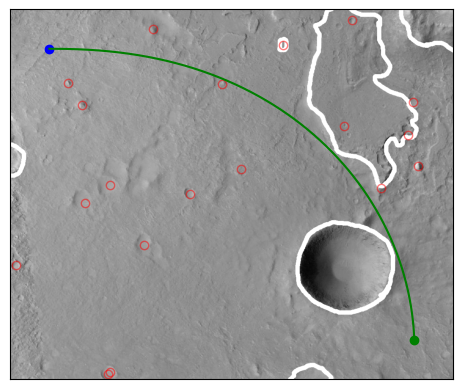

In [6]:

### - 1.1) Plot the trajectory of the rover in the map from 
###        P0 = (42.38, 11.59)km to P1 = (33.07,19.01)km
q_path = Path(q[:,0:2], 'g-')
mars_grid.plot_on([P0p,P1p, q_path], landmarks=True, submap=True)

In [ ]:
test_grid = mars_grid.submap_path(P0)

We now plot the velocity profile of the path:




In [ ]:
### 1.2) Plot the velocity profile of the rover
plot_velocity(qd)
plt.show()

We see how the control outputs a constant velocity equal to the maximum velocity of the rover. We find this behavior the optimal one, minimiziming the travel time.

The velocity components are also plotted, behaving perfectly with respect to the desired target angle. (Mettila meglio)

The heading and heading rate are shown in the following plots:

In [ ]:
plot_angle_and_rate(q, qd)
plt.show()

We see how the control quickly adjusts the initial heading and then with $\dot{\theta} \simeq 10^{-6}$ rad/s it keeps adjusting the heading along the trajectory.

This trajectory successfully meets the requirements for the final pose and avoids boundary crossing. However, it will be a poor choice for the localization task as the path approaches the forbidden regions closely, which could pose a challenge when considering positional uncertainty and measurement noise. Furthermore, there are few landmarks encountered along this trajectory.   

In Task 3 (Localization), we will explore and construct a more optimal path for localization.

# Task 2
## A* pathfinding

We are now tasked to navigate from &#128994; $P_1$ to &#128308; $P_2$. 

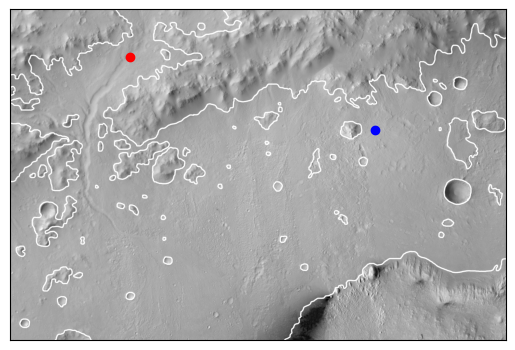

In [11]:
mars_grid.plot_on([P1p, P2p], landmarks=False, submap=False)



The path should minimize the cost function

\begin{equation*}
    f(n) = G(n) + h(n)
\end{equation*}

where `n` is the next node of the path, G(`n`) is the length of the path from the start to `n` and h(`n`) is the heuristic function evaluated as:

\begin{equation*}
    h(n) = max(dx,dy) + (\sqrt{2} - 1)min(dx,dy)
\end{equation*}
with
\begin{equation*}
    dx = |x_n - x_{goal}| , \quad dy = |y_n - y_{goal}|
\end{equation*}

The implementantion of the A* function is in `Astar.py`, and here shown in bits.


> ```python
>
> from queue import PriorityQueue
> from collections import defaultdict
> def AStar(grid, x0, x_target):
>     open_set = PriorityQueue()
>     cameFrom = {}
> 
>     gScore = defaultdict(lambda: float('inf')) # If value not in dict, return inf
>     gScore[x0] = 0
>     fScore = defaultdict(lambda: float('inf'))
>     fScore[x0] = h_oct(x0, x_target)
>     open_set.put((fScore[x0], h_oct(x0, x_target), x0))
> 
>```

We start by importing `PriorityQueue` and `defaultdict` from standard Python libraries. 

`PriorityQueue` ensures that the node returned by `open_set.get()` will be the one with the lowest f in the set. The heuristic function is used to solve equalities in f.

`defaultdict` lets us define `gScore` and `fScore` computed for each node as a dict, and it will return infinity if the node is not present in the set. We initialize the two sets with the initial position.

> ``` python
> 
>     while not open_set.empty(): 
>         
>         current = open_set.get()[2] # get only the position tuple
>         if current == x_target:
>             # return the path and the cost
>             return reconstruct_path(cameFrom, current), gScore[current]
>        
>         # compute neighbors of current -- deletes points outside of boundary or inside obstacle
>         cur_neighbors = grid.neighbors(current[0], current[1], obstacle_check=True)
>         for neighbor in cur_neighbors:
>            h_temp = h_oct(neighbor, x_target)
>            tentative_gScore = gScore[current] + cost(current, neighbor)
>            tentative_fScore = tentative_gScore + h_temp
> 
>            if tentative_fScore < fScore[neighbor]:
>                 cameFrom[neighbor] = current
>                 gScore[neighbor] = tentative_gScore
>                 fScore[neighbor] = tentative_fScore
>                 open_set.put((fScore[neighbor], h_temp, neighbor))
>
> ```

For each node in `open_set` we firstly check if we're at the target, we return the path. If not, we check our neighbours, and for each of them that do not crosses a boundary we compute its $G(n)$ and $f(n)$, storing them if the the cost function computed at this step is less than its previous one. We then add the neighbour to `open_set`.

We can now compute the optimal path from &#128308; $P_1$ to &#128994; $P_2$

In [ ]:
### TASK 2 ### -- 3min average runtime
# Go from P1 to P2

# Run A* from P0 to P1

# P2 = (10.87*10**3, 25.67*10**3)

# path2, gScore2 = AStar(mars_grid, P1, P2) # Run A* from P1 to P2
# np_path2 = np.array(path2)



In [ ]:
# ## Plot TASK 2


# plt.text(P0[0]/10, P0[1]/10+50, 'P0', color='blue', fontsize=12)
# plt.text(P1[0]/10, P1[1]/10+70, 'P1', color='red', fontsize=12)
# plt.text(P2[0]/10, P2[1]/10+70, 'P2', color='green', fontsize=12)

# plt.show()
# print("Cost from P0 to P1: ", gScore)
# print("Cost from P1 to P2: ", gScore2)
# print("Total cost: ", gScore + gScore2)


# Task 3

In [ ]:
### TASK 3 ### 

## Dead reckoning with odomoter only
# We have a trajectory q integrated each 1s, and the odometer has
# a frequency of 1hz, so we're good

r_traj = q # trajectory of the rover

# Stdev on initial rover position
sigma_x = 6 # [m] standard deviation of the rover position
sigma_y = 6 # [m] *standard deviation of the rover position
sigma_theta = np.deg2rad(1) # [rad] standard deviation of the rover orientation

# odometer noise 
sigma_d  = 4*10**(-3) # [m] standard deviation of the distance measurement
sigma_phi = np.deg2rad(0.05) # [rad] standard deviation of the angle measurement

p0 = np.eye(3)*[sigma_x**2, sigma_y**2, sigma_theta**2] # initial covariance matrix


dr_traj, dr_p = dead_recon(r_traj, p0, sigma_d, sigma_phi)

In [ ]:
plt.figure()
plt.ylabel("det(P)")
det_p = np.zeros(len(dr_p))
for i in range(len(dr_p)):
    det_p[i] = np.sqrt(np.linalg.det(dr_p[i]))
plt.plot(det_p)

# Plot error from real trajectory
plt.figure()
plt.title("Error from real trajectory")
plt.ylabel("e (m)")
plt.plot(np.sqrt((dr_traj[:,0] - r_traj[:,0])**2 + (dr_traj[:,1] - r_traj[:,1])**2))

In [ ]:
submap.plot()
# Plot real trajectory 

plt.plot(dr_traj[:,0]/10 - submap.x_off/10, dr_traj[:,1]/10 - submap.y_off/10, 'r')
plt.plot(r_traj[:,0]/10 - submap.x_off/10, r_traj[:,1]/10 - submap.y_off/10, 'b--')
# Plot 3 sigma ellipse of the rover position
plt.show()

In [ ]:
# Dead reckoning with odomoter + landmark measurements
lidar_range = 500 # [m] maximum range of the lidar
sigma_rho = 0.1 # [m] standard deviation of the rho measurement
sigma_beta = np.deg2rad(0.25) # [rad] standard deviation of the beta measurement
# problematic landmark at [array([37482., 18113.])]
# first landmark at [array([41542., 15452.])] -- idx = 89663

ekf_traj, ekf_p = EKF(mars_grid, r_traj, p0, sigma_d, sigma_phi, sigma_rho, sigma_beta, lidar_range)

In [ ]:
plt.figure()


plt.ylabel("det(P)")
det_p = np.zeros(len(ekf_p))
for i in range(len(ekf_p)):
    det_p[i] = np.sqrt(np.linalg.det(ekf_p[i]))
plt.plot(det_p)


In [ ]:
error = np.sqrt((ekf_traj[:,0] - r_traj[:,0])**2 + (ekf_traj[:,1] - r_traj[:,1])**2)
pose_error = np.sqrt((ekf_traj[:,2] - r_traj[:,2])**2)

# Plot error from real trajectory
plt.figure()
plt.title("Error from real trajectory")
plt.ylabel("e (m)")

plt.plot(error[:])

# pose error
plt.figure()
plt.title("Azimuth error")
plt.ylabel("e (rad)")
plt.plot(pose_error[:])
# 150000


In [ ]:
fig = plt.figure()
ax = fig.gca()
submap.plot()
for landmark in submap.landmarks:
    plt.plot(landmark[0]/10 - submap.x_off/10, landmark[1]/10 - submap.y_off/10, 'yo')
# Plot real trajectory 
plt.plot(P0[0]/10 - submap.x_off/10, P0[1]/10 - submap.y_off/10, 'bo')
plt.plot(P1[0]/10 - submap.x_off/10, P1[1]/10 - submap.y_off/10, 'ro')    

plt.plot(r_traj[:,0]/10 - submap.x_off/10, r_traj[:,1]/10 - submap.y_off/10, 'b')
plt.plot(ekf_traj[:,0]/10- submap.x_off/10, ekf_traj[:,1]/10 - submap.y_off/10, 'g')

# step in ekf_traj with a step of 1000
for i in range(0, len(ekf_traj), 5000):
    ellipse = error_ellipse(ekf_traj[i,0]/10 - submap.x_off/10, ekf_traj[i,1]/10 - submap.y_off/10, ekf_p[i][0:2,0:2])
    ax.add_artist(ellipse)
    ellipse.set_alpha(0.3)
    ellipse.set_facecolor('none')
    ellipse.set_edgecolor('r')
    ellipse.set_linestyle('--')

plt.show()